In [ ]:
!pip install surprise

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 772.0/772.0 kB 11.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.3-cp310-cp310-linux_x86_64.whl size=3095457 sha256=765e09487d7d5f903ecec5c6647654b37dba6bd780d0e36130d9a8a2910c5bc7
  Stored in directory: /root/.cache/pip/wheels/a5/ca/a8/4e28def53797fdc4363ca4af740db15a9c2f1595ebc51fb445
Successfully built scikit-surprise


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
from surprise import SVD, KNNBasic
from surprise import Dataset
from surprise.model_selection import cross_validate
from surprise.model_selection import GridSearchCV
from surprise.reader import Reader

In [ ]:
data = Dataset.load_builtin('ml-100k', prompt = False)

In [ ]:
from surprise import BaselineOnly
bsl_options = {'method': 'sgd',
               'n_epochs': 5,
               'reg_u': 12,
               'reg_i': 5
               }
algo = BaselineOnly(bsl_options=bsl_options)
cross_validate(algo, data, measures=['RMSE'], cv=3, verbose=False)

Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...


{'test_rmse': array([0.96022763, 0.96055991, 0.95749395]),
 'fit_time': (0.14301681518554688, 0.1758575439453125, 0.17640995979309082),
 'test_time': (0.15261530876159668, 0.264542818069458, 0.14538240432739258)}

> Question: Change the method parameter by replacing sgd by als. Is the rms improving?

In [ ]:
from surprise import BaselineOnly
bsl_options = {'method': 'als',
               'n_epochs': 5,
               'reg_u': 12,
               'reg_i': 5
               }
algo = BaselineOnly(bsl_options=bsl_options)
cross_validate(algo, data, measures=['RMSE'], cv=3, verbose=False)

Estimating biases using als...
Estimating biases using als...
Estimating biases using als...


{'test_rmse': array([0.94447158, 0.94442329, 0.9437876 ]),
 'fit_time': (0.21609091758728027, 0.1817317008972168, 0.17545413970947266),
 'test_time': (0.30545711517333984, 0.2771172523498535, 0.15857625007629395)}

In [ ]:

# Let's use SVD seen in the course.
algo = SVD()
#  5-fold cross-validation showing results
cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9332  0.9331  0.9403  0.9376  0.9317  0.9352  0.0032  
MAE (testset)     0.7372  0.7351  0.7385  0.7378  0.7349  0.7367  0.0014  
Fit time          1.96    1.38    1.40    1.34    1.35    1.49    0.24    
Test time         0.25    0.17    0.26    0.20    0.14    0.20    0.05    


{'test_rmse': array([0.93324366, 0.93314769, 0.94028752, 0.93763963, 0.93169185]),
 'test_mae': array([0.73724911, 0.73511617, 0.73849728, 0.73779712, 0.73494231]),
 'fit_time': (1.9600512981414795,
  1.3837592601776123,
  1.400336503982544,
  1.3350582122802734,
  1.3528707027435303),
 'test_time': (0.25365161895751953,
  0.16825294494628906,
  0.26096558570861816,
  0.1968824863433838,
  0.14217925071716309)}

## this SVD  is said to be biased:
https://surprise.readthedocs.io/en/stable/matrix_factorization.html#matrix-factorization-based-algorithms

## we will specify the optimal number of factors using GreadSearchCV.

In [ ]:
param_grid = {'n_factors': [4,6,9,11,14,18,29]}
gs = GridSearchCV(SVD, param_grid, measures=['rmse'], cv=5)
gs.fit(data)


# the best RMSE
print(gs.best_score['rmse'])

# parameters behind this performance
print(gs.best_params['rmse'])

0.9347514856960103
{'n_factors': 18}


## To get this number of factors in a more concise way, we will use cross-validation by proving it graphically

In [ ]:
def rmse_vs_factors(algorithm, data):



    rmse_algorithm = []

    for k in range(4,20,1):
        algo = algorithm(n_factors = k)

        #["test_rmse"] is a numpy array with the min RMSE in each test set
        loss_fce = cross_validate(algo, data, measures=['RMSE'], cv=5, verbose=False)["test_rmse"].mean()
        rmse_algorithm.append(loss_fce)

    return rmse_algorithm

In [ ]:
rmse_svd = rmse_vs_factors(SVD,data)

In [ ]:
def plot_rmse(rmse, algorithm):
    plt.figure(num=None, figsize=(11, 5), dpi=80, facecolor='w', edgecolor='k')

    plt.subplot(2,1,1)
    plt.plot(rmse)
    plt.xlim(0,20)
    plt.title("{0} Performance: RMSE contre le nbre de Facteurs".format(algorithm), size = 20 )
    plt.ylabel("Mean RMSE (cv=5)")

    plt.subplot(2,1,2)
    plt.plot(rmse)
    plt.xlim(0,20)
    plt.xticks(np.arange(0, 20, step=2))

    plt.xlabel("{0}(facteur = k)".format(algorithm))
    plt.ylabel("Mean RMSE (cv=5)")
    plt.axvline(np.argmin(rmse), color = "r")



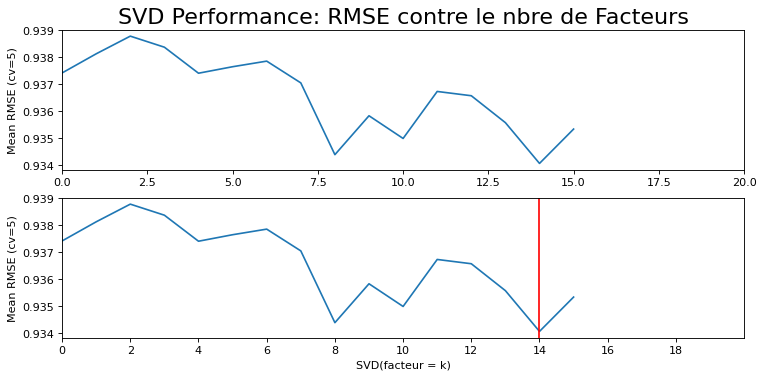

In [ ]:
plot_rmse(rmse_svd,"SVD")

### Questions:

the different parameters of the SVD: https://surprise.readthedocs.io/en/stable/matrix_factorization.html#matrix-factorization-based-algorithms
also: https://surprise.readthedocs.io/en/stable/basic_algorithms.html#surprise.prediction_algorithms.baseline_only.BaselineOnly

1. Using GridSearchCV show the best combination of parameters for the baselineonly version
2. Using GridSearchCV, display the best combination of parameters for the biased version
3. Same question for the unbiased version
4. redo the same work (i.e., 1 and 2 and 3) using RandomizedSearchCV

1. Using GridSearchCV show the best combination of parameters for the baselineonly version

In [ ]:

param_grid = {
    'bsl_options': {
        'method': ['als', 'sgd'],
        'reg_u': [12,9],
        'reg_i': [5,6],
        'n_epochs': [3,2]
    }
}


gs = GridSearchCV(BaselineOnly, param_grid, measures=['rmse'], cv=5)
gs.fit(data)

# Print the best RMSE score
print(gs.best_score['rmse'])

# Print the parameters behind the best performance
print(gs.best_params['rmse'])


Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimati

2. Using GridSearchCV, display the best combination of parameters for the biased version

In [ ]:
param_grid = {
               'reg_qi': [5, 12, 18],
               'reg_pu': [5, 10, 15],
               'reg_bi': [6, 15, 14],
               'reg_bu': [5, 11, 19]
               }

gs = GridSearchCV(SVD, param_grid, measures=['rmse'], cv=5)
gs.fit(data)


# the best RMSE
print(gs.best_score['rmse'])

# parameters behind this performance
print(gs.best_params['rmse'])

1.0728279787821844
{'reg_qi': 5, 'reg_pu': 15, 'reg_bi': 6, 'reg_bu': 5}


3. Same question for the unbiased version



In [ ]:
param_grid = {
               'reg_qi': [5, 12, 18],
               'reg_pu': [5, 10, 15],
               'biased':[False]
               }

gs = GridSearchCV(SVD, param_grid, measures=['rmse'], cv=5)
gs.fit(data)


# the best RMSE
print(gs.best_score['rmse'])

# parameters behind this performance
print(gs.best_params['rmse'])

2.7689172594860114
{'reg_qi': 5, 'reg_pu': 5, 'biased': False}


4. redo the same work (i.e., 1 and 2 and 3) using RandomizedSearchCV

In [ ]:
from surprise.model_selection import RandomizedSearchCV

In [ ]:
param_grid = {
               'reg_qi': list(range(5,15)),
               'reg_pu': list(range(10,20)),
               'biased':[False]
               }

gs = RandomizedSearchCV(SVD, param_grid, measures=['rmse'], cv=5)
gs.fit(data)


# the best RMSE
print(gs.best_score['rmse'])

# parameters behind this performance
print(gs.best_params['rmse'])

2.768760512393152
{'reg_qi': 8, 'reg_pu': 17, 'biased': False}
